BYOL (Bootstrap Your Own Latent)

In [1]:
#1. Import Libraries and Prepare Data
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
train = pd.read_parquet("/kaggle/input/unsw-nb15/UNSW_NB15_training-set.parquet")
test = pd.read_parquet("/kaggle/input/unsw-nb15/UNSW_NB15_testing-set.parquet")
df = pd.concat([train, test])
df = df.drop(columns=['id', 'attack_cat'], errors='ignore')

# Preprocessing
cat_cols = ['proto', 'service', 'state']
for col in cat_cols:
    df[col] = pd.factorize(df[col])[0]

X = df.drop('label', axis=1)
y = df['label']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

2025-06-21 17:42:58.277770: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750527778.706483      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750527778.822966      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
#2. Define BYOL Model Components
def build_encoder(input_dim):
    """Defines the encoder network for BYOL."""
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(256, activation='swish')(inputs)
    x = layers.Dense(128, activation='swish')(x)
    projection = layers.Dense(64)(x)
    return models.Model(inputs, projection)

def momentum_update(query_encoder, target_encoder, m=0.99):
    """Momentum update of target encoder."""
    for q_var, t_var in zip(query_encoder.variables, target_encoder.variables):
        t_var.assign(m * t_var + (1 - m) * q_var)

def augment_batch(X):
    """Augmentation function to generate noisy inputs."""
    mask = (np.random.rand(*X.shape) > 0.15).astype(np.float32)
    noise = np.random.normal(0, 0.05, size=X.shape).astype(np.float32)
    return X * mask + noise

In [3]:
#Define Training Loop and Downstream Classifier
ratios = [(10, 90), (20, 80), (30, 70), (40, 60), (50, 50), (60, 40), (70, 30), (80, 20), (90, 10)]

all_results = []

for train_pct, test_pct in ratios:
    print(f"\n--- Train:Test = {train_pct}:{test_pct} ---")

    # Split data according to the ratio
    X_train, X_test, y_train, y_test = train_test_split(
        X.values.astype(np.float32), y.values,
        test_size=test_pct / 100,
        stratify=y,
        random_state=42
    )

    # Initialize the encoders (online and target)
    query_encoder = build_encoder(X_train.shape[1])
    target_encoder = build_encoder(X_train.shape[1])
    
    # Initialize target encoder weights with online encoder weights (momentum update)
    for q_var, t_var in zip(query_encoder.variables, target_encoder.variables):
        t_var.assign(q_var)

    # Set up optimizer
    optimizer = tf.keras.optimizers.Adam(3e-4)
    batch_size = 512
    epochs = 20
    num_samples = X_train.shape[0]

    # Training loop for BYOL
    for epoch in range(epochs):
        idx = np.random.permutation(num_samples)
        X_shuffled = X_train[idx]

        for i in range(0, num_samples, batch_size):
            batch = X_shuffled[i:i + batch_size]
            if batch.shape[0] < 2:
                continue

            # Augmentation
            x_q = augment_batch(batch)  # Query augmentation
            x_k = augment_batch(batch)  # Key augmentation

            with tf.GradientTape() as tape:
                z_q = query_encoder(x_q, training=True)
                z_k = target_encoder(x_k, training=True)
                loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
                    labels=tf.zeros(z_q.shape[0], dtype=tf.int32),
                    logits=tf.matmul(tf.math.l2_normalize(z_q, axis=1), tf.math.l2_normalize(z_k, axis=1), transpose_b=True)
                ))

            grads = tape.gradient(loss, query_encoder.trainable_variables)
            optimizer.apply_gradients(zip(grads, query_encoder.trainable_variables))

            # Momentum update of target encoder
            momentum_update(query_encoder, target_encoder)

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.numpy():.4f}")

        # Evaluate downstream classifier (RandomForest)
        X_train_ssl = query_encoder.predict(X_train)
        X_test_ssl = query_encoder.predict(X_test)

        rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
        rf.fit(X_train_ssl, y_train)
        y_pred = rf.predict(X_test_ssl)
        report = classification_report(y_test, y_pred, output_dict=True)

        acc = report['accuracy']
        f1_0 = report['0']['f1-score']
        f1_1 = report['1']['f1-score']

        all_results.append({
            'train_pct': train_pct,
            'test_pct': test_pct,
            'epoch': epoch + 1,
            'loss': float(loss.numpy()),
            'accuracy': acc,
            'f1_class_0': f1_0,
            'f1_class_1': f1_1
        })

        print(f"Accuracy: {acc:.4f}, F1 Class 0: {f1_0:.4f}, F1 Class 1: {f1_1:.4f}")


#Save the Results to CSV
# -------- Step 5: Save results --------
results_df = pd.DataFrame(all_results)
results_df.to_csv('byol_ssl_rf_results_all_epochs.csv', index=False)
print("\nSaved results to 'byol_ssl_rf_results_all_epochs.csv'")


--- Train:Test = 10:90 ---


I0000 00:00:1750528014.106237      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750528014.106948      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/20, Loss: 0.0000


I0000 00:00:1750528021.857639     102 service.cc:148] XLA service 0x7993f000fd40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750528021.859247     102 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1750528021.859267     102 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1750528021.993634     102 cuda_dnn.cc:529] Loaded cuDNN version 90300


128/806 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

I0000 00:00:1750528022.379602     102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


806/806 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
7248/7248 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
Accuracy: 0.9034, F1 Class 0: 0.8616, F1 Class 1: 0.9258
Epoch 2/20, Loss: 0.0000
806/806 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
7248/7248 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
Accuracy: 0.9004, F1 Class 0: 0.8566, F1 Class 1: 0.9237
Epoch 3/20, Loss: 0.0000
806/806 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
7248/7248 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
Accuracy: 0.8987, F1 Class 0: 0.8538, F1 Class 1: 0.9225
Epoch 4/20, Loss: 0.0000
806/806 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
7248/7248 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
Accuracy: 0.8984, F1 Class 0: 0.8533, F1 Class 1: 0.9223
Epoch 5/20, Loss: 0.0000
806/806 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
7248/7248 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
Accuracy: 0.8977, F1 Class 0: 0.8523, F1 Class 1: 0.9218
Epoch 6/20, Loss: 0.0000
806/806 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
7248/7248 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
Accuracy: 0.8980, F1 Class 0: 0.8525, F1 Class 1: 0.9220
Epoch 7/20, Loss: 0.0000
806/

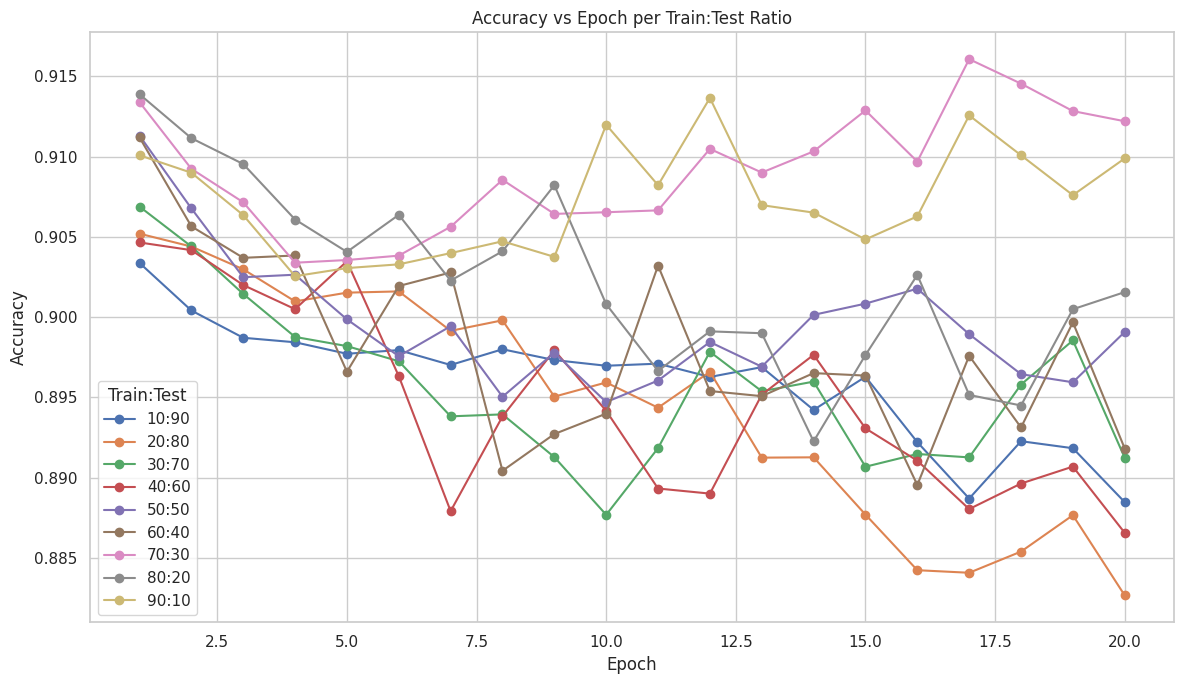

In [4]:
#Visualization of Results
# Set style for plots
sns.set(style="whitegrid")
ratios_unique = results_df[['train_pct', 'test_pct']].drop_duplicates()

# Accuracy vs Epoch
plt.figure(figsize=(12, 7))
for _, row in ratios_unique.iterrows():
    subset = results_df[
        (results_df['train_pct'] == row['train_pct']) & 
        (results_df['test_pct'] == row['test_pct'])
    ]
    label = f"{int(row['train_pct'])}:{int(row['test_pct'])}"
    plt.plot(subset['epoch'], subset['accuracy'], marker='o', label=label)
plt.title("Accuracy vs Epoch per Train:Test Ratio")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(title="Train:Test")
plt.tight_layout()
plt.show()

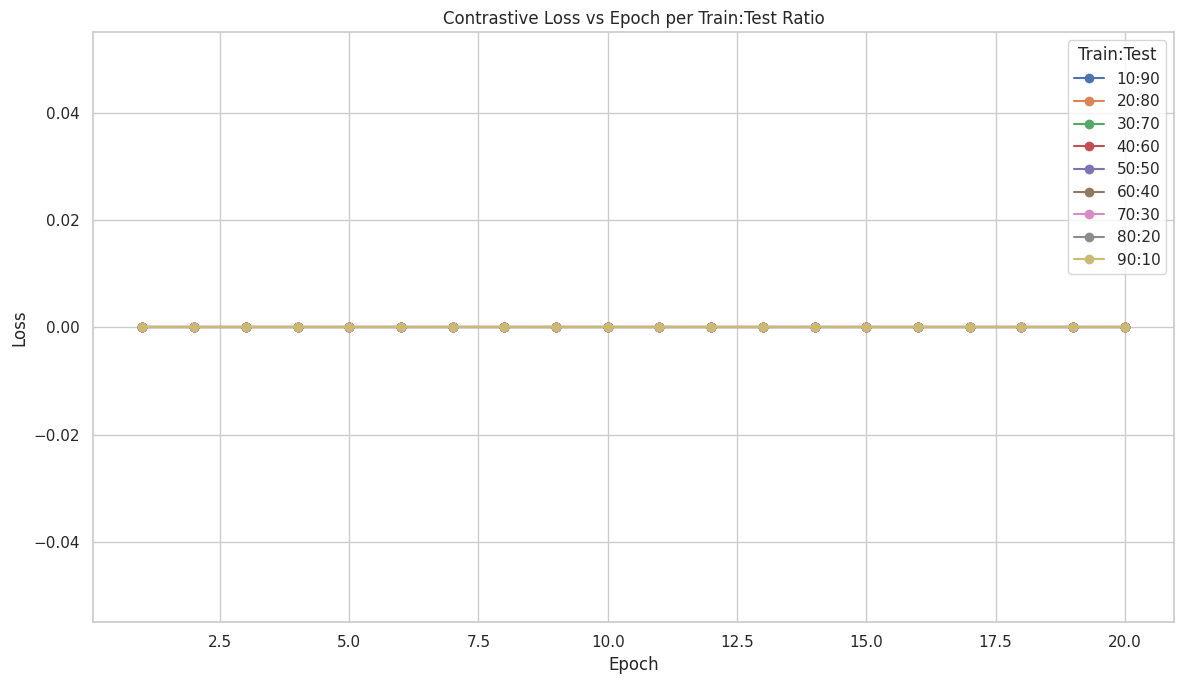

In [5]:

# Loss vs Epoch
plt.figure(figsize=(12, 7))
for _, row in ratios_unique.iterrows():
    subset = results_df[
        (results_df['train_pct'] == row['train_pct']) & 
        (results_df['test_pct'] == row['test_pct'])
    ]
    label = f"{int(row['train_pct'])}:{int(row['test_pct'])}"
    plt.plot(subset['epoch'], subset['loss'], marker='o', label=label)
plt.title("Contrastive Loss vs Epoch per Train:Test Ratio")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(title="Train:Test")
plt.tight_layout()
plt.show()